In [ ]:
import torch
from adaptive_control_gym.envs import DroneEnv
from adaptive_control_gym.controllers import PPO
from tqdm import trange
import pandas as pd

torch.set_grad_enabled(False)

n_params = 3
w_per_dim = 32
env_num = w_per_dim**n_params
search_dim = n_params
env = DroneEnv(
    env_num=env_num, gpu_id=0, seed = 1, 
    res_dyn_param_dim=0
)
res_dyn_param = torch.tensor([0.0, 0.0, 0.0], device = env.device)
agent = PPO(
    state_dim=env.state_dim, expert_dim=env.expert_dim, 
    adapt_dim=env.adapt_dim, action_dim=env.action_dim, 
    adapt_horizon=env.adapt_horizon, 
    act_expert_mode=1, cri_expert_mode=1,
    compressor_dim=n_params, search_dim=0,
    env_num=env_num, gpu_id=0)
loaded_agent = torch.load(
    '/home/pcy/rl/policy-adaptation-survey/results/rl/ppo_ood-only-disturb-center-50-com3.pt',
    map_location='cuda:0',
)
agent.act.load_state_dict(loaded_agent['actor'].state_dict())
agent.adaptor.load_state_dict(loaded_agent['adaptor'].state_dict())
agent.compressor.load_state_dict(loaded_agent['compressor'].state_dict())

w = torch.linspace(-1, 1, w_per_dim, device=env.device)
ww = torch.stack(torch.meshgrid(*([w]*n_params)), dim=-1)
ww_flatten = ww.reshape(env_num, n_params)
err_mean = torch.zeros(env_num, device=env.device)
for _ in trange(100):
    agent.last_state, agent.last_info = env.reset()
    env.disturb = torch.ones_like(env.disturb, device=env.device) * res_dyn_param
    states, actions, logprobs, rewards, undones, infos = agent.explore_env(env, env.max_steps, deterministic=True, use_adaptor=False, predefined_e=ww_flatten)
    err_mean += infos['err_x'].mean(dim=0)
err_mean /= 100
# create pandas dataframe
data = pd.DataFrame(ww_flatten.cpu().numpy(), columns=['w1', 'w2', 'w3'])
data['err'] = err_mean.cpu().numpy()
# save to csv
data.to_csv('results/err_000.csv')

In [ ]:
err_mean_reshaped = err_mean.reshape(w_per_dim, w_per_dim, w_per_dim).cpu().numpy()

In [ ]:
err_mean_reshaped.max() - err_mean_reshaped.min()

In [ ]:
# plot w0, w1 and err_mean as colormap
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure()
ax = fig.gca(projection='3d')
X, Y = np.meshgrid(w.cpu().numpy(), w.cpu().numpy())
surf = ax.plot_surface(X, Y, err_mean_reshaped[:, :, 31], cmap=cm.coolwarm,
                        linewidth=0, antialiased=False)  
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [ ]:
import numpy as np
compressed_value = agent.compressor(res_dyn_param).detach().cpu().numpy()
compressed_idx = (compressed_value / (2/w_per_dim)+w_per_dim/2).astype(np.int)
compressed_value = err_mean[compressed_idx[1], compressed_idx[0]]

In [ ]:
# plot err_mean
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(err_mean, cmap='jet')
plt.colorbar()
# rescale x, y axis
plt.xticks([0, w_per_dim-1], [-1, 1])
plt.yticks([0, w_per_dim-1], [-1, 1])
# show the point with min value
min_idx = np.unravel_index(np.argmin(err_mean, axis=None), err_mean.shape)
min_value = err_mean[min_idx]
plt.scatter(min_idx[1], min_idx[0], marker='x', color='red', s=100, label='searched minimum point')
plt.text(min_idx[1], min_idx[0]-2, f'{min_value:.2f}', color='red')
# show the compressed value
plt.scatter(compressed_idx[1], compressed_idx[0], marker='x', color='green', s=100, label='compressed point')
plt.text(compressed_idx[1]+2, compressed_idx[0]+2, f'{compressed_value:.2f}', color='green')
plt.legend()
plt.title('Error Mean along 2D Search Space, 100 runs, tested on [-1,-1]')

visualize high-dimentionsal input-output space. 

In [21]:
# load compressor
import torch
loaded_agent = torch.load('/home/pcy/rl/policy-adaptation-survey/results/rl/ppo_ood-only-disturb-center-50-com5.pt', map_location='cuda:0')
err = loaded_agent['expert_err_x_final']
compressor = loaded_agent['compressor']

In [22]:
# generate data point from a sphere with torch
r = 0.8/0.3
n = 100
theta = torch.linspace(0, 2*torch.pi, n, device='cuda:0')
phi = torch.linspace(0, torch.pi, n, device='cuda:0')
x = r * torch.outer(torch.cos(theta), torch.sin(phi))
y = r * torch.outer(torch.sin(theta), torch.sin(phi))
z = r * torch.outer(torch.ones_like(theta), torch.cos(phi))
x = x.reshape(-1)
y = y.reshape(-1)
z = z.reshape(-1)
data = torch.stack([x, y, z], dim=1)

In [23]:
# get output by compressor
torch.set_grad_enabled(False)
compressed_data = compressor(data)

/home/pcy/miniconda3/envs/rlgpu/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/pcy/miniconda3/envs/rlgpu/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/pcy/miniconda3/envs/rlgpu/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/pcy/miniconda3/envs/rlgpu/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


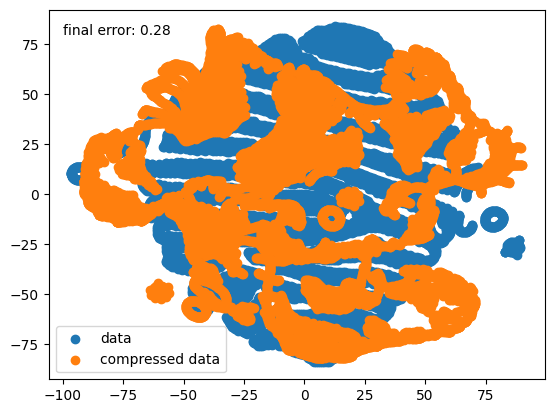

In [24]:
# visualize data and compressed_data with t-SNE
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
tsne = TSNE(n_components=2, random_state=0)
data_2d = tsne.fit_transform(data.cpu().numpy())
compressed_data_2d = tsne.fit_transform(compressed_data.cpu().numpy())
plt.scatter(data_2d[:, 0], data_2d[:, 1], label='data')
plt.scatter(compressed_data_2d[:, 0], compressed_data_2d[:, 1], label='compressed data')
# add final error text at left top corner
plt.text(-100, 80, f'final error: {err:.2f}')
plt.legend()
